In [76]:
 %tensorflow_version 1.2


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.2`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
!pip install analytics-zoo

     |████████████████████████████████| 158.9MB 81kB/s 
     |████████████████████████████████| 114.1MB 82kB/s 
     |████████████████████████████████| 215.6MB 49kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.3-py2.py3-none-any.whl size=215964964 sha256=10fa8aa9e3d23873f371706361447b6775c394a8333cca37211800fe177ae3b6
  Stored in directory: /root/.cache/pip/wheels/8d/20/f0/b30e2024226dc112e256930dd2cd4f06d00ab053c86278dcf3
Successfully built pyspark


In [77]:
import cv2
import tensorflow as tf
# print(tensorflow.__version__)
import numpy as np
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression
from keras.layers import Conv2D, MaxPool2D,  Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D,Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD
import keras as keras
from keras.layers.core import Layer
import keras.backend as K
from keras.utils import np_utils
import math 
from keras.callbacks import LearningRateScheduler

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Creating Labels**

In [79]:
def my_label(image_name):
    name = image_name.split('.')[-3]
    print(name)
    
    if name =="Shamik":
        return np.array([1,0])
    elif name == "Yash":
        return np.array([0,1])
        

In [80]:
import os
from random import shuffle
from tqdm import tqdm

In [81]:
def my_data():
    data = []
    for img in tqdm(os.listdir("/content/drive/MyDrive/face_train_data")):
        path=os.path.join("/content/drive/MyDrive/face_train_data",img)
        img_data = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        data.append([np.array(img_data), my_label(img)])
    shuffle(data)  
    return data

In [82]:
data = my_data()



 70%|██████▉   | 57/82 [00:00<00:00, 285.59it/s]

Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Shamik
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash


100%|██████████| 82/82 [00:00<00:00, 269.88it/s]

Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash
Yash


# **Creating Dataset**

In [83]:
train = data[:72]  
test = data[72:]
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
print(X_train.shape)
y_train = [i[1] for i in train]
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
print(X_test.shape)
y_test = [i[1] for i in test]

(72, 50, 50, 1)
(10, 50, 50, 1)


# **Dataset Analysis**

In [91]:
path1 = "/content/drive/MyDrive/face_train_data/Yash.2.jpg"
image = cv2.imread(path1)
print(image)
print('Type of the image : ' , type(image))

print('Shape of the image : {}'.format(image.shape))
print('Image Height {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))


[[[123 123 123]
  [125 125 125]
  [124 124 124]
  ...
  [160 160 160]
  [166 166 166]
  [189 189 189]]

 [[139 139 139]
  [143 143 143]
  [136 136 136]
  ...
  [172 172 172]
  [191 191 191]
  [184 184 184]]

 [[150 150 150]
  [154 154 154]
  [138 138 138]
  ...
  [187 187 187]
  [190 190 190]
  [192 192 192]]

 ...

 [[242 242 242]
  [238 238 238]
  [234 234 234]
  ...
  [132 132 132]
  [125 125 125]
  [119 119 119]]

 [[243 243 243]
  [238 238 238]
  [232 232 232]
  ...
  [129 129 129]
  [132 132 132]
  [134 134 134]]

 [[243 243 243]
  [231 231 231]
  [217 217 217]
  ...
  [139 139 139]
  [147 147 147]
  [151 151 151]]]
Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (200, 200, 3)
Image Height 200
Image Width 200
Dimension of Image 3


In [92]:
print('Image size {}'.format(image.size))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Image size 120000
Maximum RGB value in this image 252
Minimum RGB value in this image 0


# **Image Segmentation Using K-Means Clustering**

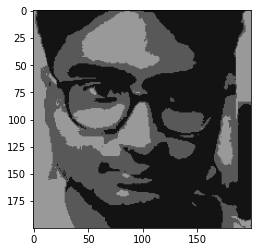

In [96]:
from sklearn import cluster

import matplotlib.pyplot as plt


# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))
  

pixel_vals = np.float32(pixel_vals)



criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
  

k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
  

segmented_image = segmented_data.reshape((image.shape))
  
plt.imshow(segmented_image)

# **Making The Model**

# **1. Tensorflow Model Architecture (As per Docs) And Improvisation**

In [86]:
tf.reset_default_graph()
convnet = input_data(shape=[50,50,1])
convnet = conv_2d(convnet, 32, 5, activation='relu')

# 64 filters and stride=5 so that the filter will move 5 pixel or unit at a time

convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

#CNN Network with 1024 layers

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', metric='accuracy', learning_rate = 0.001, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=3)

model.fit(X_train, y_train, n_epoch=12, validation_set=(X_test, y_test), show_metric = True, run_id="face_recognition" )



Training Step: 23  | total loss: 0.74801 | time: 0.091s
| Adam | epoch: 012 | loss: 0.74801 - acc: 0.8418 -- iter: 64/72
Training Step: 24  | total loss: 0.54524 | time: 1.187s
| Adam | epoch: 012 | loss: 0.54524 - acc: 0.8863 | val_loss: 0.02137 - val_acc: 1.0000 -- iter: 72/72
--


# **2. AlexNet Implementation And Improvisation**

In [ ]:
tf.reset_default_graph()
convnet = input_data(shape=[50,50,1])
convnet = conv_2d(convnet, 96,(11,11), 4, activation='relu')
# 32 filters and stride=3 so that the filter will move 3  pixel or unit at a time
convnet = max_pool_2d(convnet, 3)
convnet = conv_2d(convnet, 256, 5, strides=4, activation='relu')
convnet = max_pool_2d(convnet, 3, strides=2)
convnet = conv_2d(convnet, 256, 5, strides=4, activation='relu')
convnet = max_pool_2d(convnet, 3,strides=2)
convnet = conv_2d(convnet, 384, 3, strides=4, activation='relu')
convnet = conv_2d(convnet, 384, 3, strides=4, activation='relu')
convnet = conv_2d(convnet, 256, 3, strides=4, activation='relu')
convnet = max_pool_2d(convnet, 3, strides=2)

#CNN Network with 4096 layers

convnet = fully_connected(convnet, 4096, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
sgd = tflearn.optimizers.SGD(learning_rate=0.01, lr_decay=0.96, decay_step=100)
convnet = regression(convnet, optimizer=sgd, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=1)
model.fit(X_train, y_train, n_epoch=8, validation_set=(X_test, y_test), show_metric = True, run_id="face_recognition" )

Training Step: 11  | total loss: 0.65132 | time: 0.319s
| SGD | epoch: 006 | loss: 0.65132 - acc: 0.9206 -- iter: 64/75
Training Step: 12  | total loss: 0.64503 | time: 1.668s
| SGD | epoch: 006 | loss: 0.64503 - acc: 0.8745 | val_loss: 0.61366 - val_acc: 1.0000 -- iter: 75/75
--


# **VGGNet 16 Implementation And Improvisation**

In [ ]:
tf.reset_default_graph()
convnet = input_data(shape=[50,50,1])
convnet = conv_2d(convnet, 64, 3, activation='sigmoid')
convnet = conv_2d(convnet, 64, 3, activation='sigmoid')
convnet = max_pool_2d(convnet, 3, strides=2)
convnet = conv_2d(convnet, 128, 3, activation='sigmoid')
convnet = conv_2d(convnet, 128, 3, activation='sigmoid')
convnet = max_pool_2d(convnet, 3)
convnet = conv_2d(convnet, 256, 3, activation='sigmoid')
convnet = conv_2d(convnet, 256, 3, activation='sigmoid')
convnet = conv_2d(convnet, 256, 3, activation='sigmoid')
convnet = conv_2d(convnet, 256, 3, activation='sigmoid')
convnet = max_pool_2d(convnet, 3)
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = max_pool_2d(convnet, 3, strides=2)
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = conv_2d(convnet, 512, 3, activation='sigmoid')
convnet = max_pool_2d(convnet, 3)

#CNN Network with 4096 layers

convnet = fully_connected(convnet, 4096, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
sgd = tflearn.optimizers.SGD(learning_rate=0.01, lr_decay=0.96, decay_step=100)
convnet = regression(convnet, optimizer=sgd, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=1)
model.fit(X_train, y_train, n_epoch=8, validation_set=(X_test, y_test), show_metric = True, run_id="face_recognition" )

---------------------------------
Run id: face_recognition
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 60
Validation samples: 22
--
Training Step: 1  | time: 10.630s
| SGD | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 0.73843 - val_acc: 0.5000 -- iter: 60/60
--
Training Step: 2  | total loss: 0.66625 | time: 10.689s
| SGD | epoch: 002 | loss: 0.66625 - acc: 0.3300 | val_loss: 0.73115 - val_acc: 0.5000 -- iter: 60/60
--
Training Step: 3  | total loss: 0.64968 | time: 10.628s
| SGD | epoch: 003 | loss: 0.64968 - acc: 0.5782 | val_loss: 0.73377 - val_acc: 0.5000 -- iter: 60/60
--
Training Step: 4  | total loss: 0.65402 | time: 10.591s
| SGD | epoch: 004 | loss: 0.65402 - acc: 0.6195 | val_loss: 0.72829 - val_acc: 0.5000 -- iter: 60/60
--
Training Step: 5  | total loss: 0.65008 | time: 10.682s
| SGD | epoch: 005 | loss: 0.65008 - acc: 0.6291 | val_loss:

# **Visualizing Data And Making Predictions**

In [ ]:
def data_for_visualization():
  Vdata=[]
  for img in tqdm(os.listdir("/content/drive/MyDrive/face_test_data")):
    path = os.path.join("/content/drive/MyDrive/face_test_data",img)
    img_num = img.split('.')[1]
    img_data = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img_data = cv2.resize(img_data,(50,50))
    Vdata.append([np.array(img_data),img_num])
  shuffle(Vdata)
  return Vdata
  




In [ ]:
Vdata = data_for_visualization()

 88%|████████▊ | 35/40 [00:08<00:01,  3.40it/s]

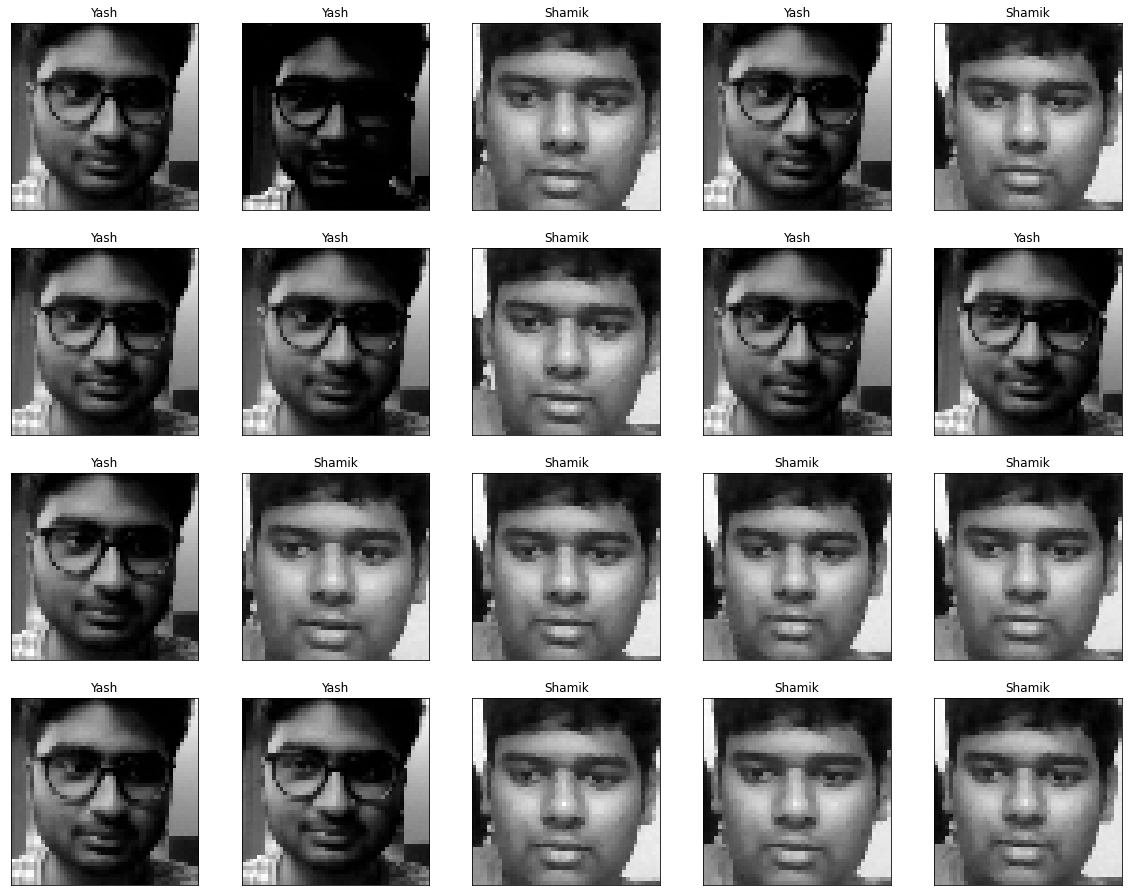

In [87]:

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
for num,data in enumerate(Vdata[:20]):
  img_data = data[0]
  y = fig.add_subplot(5,5, num+1)
  image = img_data
  data = img_data.reshape(50,50,1)
  model_out = model.predict([data])[0]

  #Gives the index no of max argument value
  #Refer Check Labels section to understand more about it
  if np.argmax(model_out) == 0:
    my_label = 'Shamik'
  elif np.argmax(model_out) == 1:
    my_label = 'Yash'
  
  y.imshow(image,cmap='gray')
  plt.title(my_label)

  #Remove X-Axis And Y-Axis Line
  y.axes.get_xaxis().set_visible(False)
  y.axes.get_yaxis().set_visible(False)

plt.show()
  